In [3]:
import numpy as np
import pandas as pd
from numpy.linalg import pinv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from scipy.stats import ranksums 
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import rankdata, friedmanchisquare
import scikit_posthocs as sp

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
GROUPS = {
    "NASA": ["pc1", "cm1", "mc2", "mw1"],
    "AEEEM": ["jdt", "pde", "ml"],
    "MORPH": ["ant-1.3", "arc", "camel-1.0"],
    "JIRA": ["activemq-5.0.0", "hbase-0.94.0", "hive-0.9.0",
             "groovy-1_6_BETA_1", "jruby-1.1"]
}
DATASETS = sum(GROUPS.values(), [])

In [4]:
USE_PCA = True
PCA_COMPONENTS = 20
H_LB, H_UB = 5, 200
POP_SIZE, MAX_ITER = 25, 30

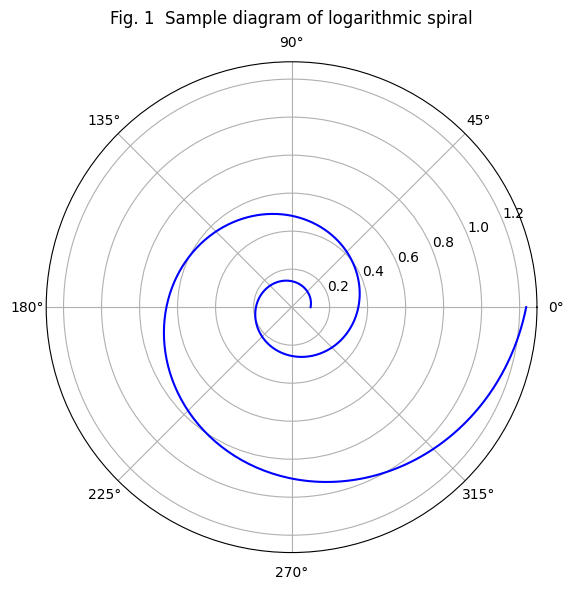

In [5]:
### Logarithmic Spiral Plot (from original code)
plt.figure(figsize=(6, 6))
theta = np.linspace(0, 4 * np.pi, 500)
a = 0.1
b = 0.2
r = a * np.exp(b * theta)
ax = plt.subplot(111, polar=True)
ax.plot(theta, r, color='blue')
ax.set_title("Fig. 1  Sample diagram of logarithmic spiral", va='bottom')
plt.tight_layout()
plt.show()

In [148]:
table_data = {
    "Algorithm": ["SSA", "AVSSA1", "AVSSA2", "AVSSA"],
    "Parameters": [
        "ST=0.8, PD=0.2, SD=0.1",
        "ST=0.8, PD=0.2, SD=0.1, w0=1, c=0.9",
        "ST=0.8, PD=0.2, SD=0.1",
        "ST=0.8, PD=0.2, SD=0.1, w0=1, c=0.9"
    ]
}

In [150]:
params_df = pd.DataFrame(table_data)
display(params_df)

,Algorithm,Parameters
0,SSA,"ST=0.8, PD=0.2, SD=0.1"
1,AVSSA1,"ST=0.8, PD=0.2, SD=0.1, w0=1, c=0.9"
2,AVSSA2,"ST=0.8, PD=0.2, SD=0.1"
3,AVSSA,"ST=0.8, PD=0.2, SD=0.1, w0=1, c=0.9"


In [15]:
def dataset_characteristics():
    rows = []
    char_no = 1
    for group, datasets in GROUPS.items():
        for name in datasets:
            X, y = load_dataset(name)
            n_samples, n_features = X.shape
            defect_rate = (np.sum(y) / len(y)) * 100
            n_pc = min(PCA_COMPONENTS, n_features) if USE_PCA else n_features
            rows.append({
                "Group": group,
                "Dataset": name,
                "Characteristic Number": char_no,
                "Number of Samples": n_samples,
                "Attribute Number": n_features,
                "Defect Rate (Eq.10)": f"{defect_rate:.2f}",
                "Principal Components": n_pc
            })
            char_no += 1
    return pd.DataFrame(rows)

In [23]:
char_df = dataset_characteristics()
print("\n\n=========== DATASET CHARACTERISTICS ===========")
display(char_df)



=========== DATASET CHARACTERISTICS ===========


,Group,Dataset,Characteristic Number,Number of Samples,Attribute Number,Defect Rate (Eq.10),Principal Components
0,NASA,pc1,1,1109,21,6.94,20
1,NASA,cm1,2,498,21,9.84,20
2,NASA,mc2,3,498,21,9.84,20
3,NASA,mw1,4,1109,21,6.94,20
4,AEEEM,jdt,5,997,61,20.66,20
5,AEEEM,pde,6,1497,61,13.96,20
6,AEEEM,ml,7,1862,61,13.16,20
7,MORPH,ant-1.3,8,125,20,16.00,20
8,MORPH,arc,9,234,20,11.54,20
9,MORPH,camel-1.0,10,339,20,3.83,20


In [152]:
table3_data = {
    "Type": ["HDSP"]*6 + ["HDMP"]*2,
    "Function": [
        "F1(x) = ∑ xi^2",
        "F2(x) = ∑ |xi| + ∏ |xi|",
        "F3(x) = ∑ (∑ xj)^2",
        "F4(x) = max |xi|",
        "F5(x) = ∑ [100(xi+1 − xi²)² + (xi − 1)²]",
        "F6(x) = ∑ ⌊xi + 0.5⌋²",
        "F7(x) = ∑ i·xi⁴ + random(0,1)",
        "F8(x) = 418.9829n − ∑ xi·sin(√|xi|)"
    ],
    "Section": [
        "[-100, 100]", "[-100, 100]", "[-100, 100]",
        "[-100, 100]", "[-30, 30]", "[-100, 100]",
        "[-1.28, 1.28]", "[-32, 32]"
    ],
    "Best": ["0"]*7 + ["-418.9829n"]
}

In [16]:
def f1(x): return np.sum(np.square(x))
def f2(x): return np.sum(np.abs(x)) + np.prod(np.abs(x))
def f3(x): return np.sum([np.square(np.sum(x[:i+1])) for i in range(len(x))])
def f4(x): return np.max(np.abs(x))
def f5(x): return np.sum([100 * (x[i+1] - x[i]**2)**2 + (x[i] - 1)**2 for i in range(len(x)-1)])
def f6(x): return np.sum(np.abs(x + 0.5)**2)
def f7(x): return np.sum([i * xi**4 for i, xi in enumerate(x, 1)]) + np.random.rand()
def f8(x): return 418.9829 * len(x) - np.sum(x * np.sin(np.sqrt(np.abs(x))))

In [17]:
BENCH_FUNCS = [f1,f2,f3,f4,f5,f6,f7,f8]

In [18]:
NAMES = ["Sphere", "Schwefel 2.22", "Schwefel 1.2", "Schwefel 2.21",
         "Rosenbrock", "Step Function", "Quartic + Noise", "Schwefel"]

In [154]:
table3_df = pd.DataFrame(table3_data)
display(table3_df)

,Type,Function,Section,Best
0,HDSP,F1(x) = ∑ xi^2,"[-100, 100]",0
1,HDSP,F2(x) = ∑ |xi| + ∏ |xi|,"[-100, 100]",0
2,HDSP,F3(x) = ∑ (∑ xj)^2,"[-100, 100]",0
3,HDSP,F4(x) = max |xi|,"[-100, 100]",0
4,HDSP,F5(x) = ∑ [100(xi+1 − xi²)² + (xi − 1)²],"[-30, 30]",0
5,HDSP,F6(x) = ∑ ⌊xi + 0.5⌋²,"[-100, 100]",0
6,HDMP,"F7(x) = ∑ i·xi⁴ + random(0,1)","[-1.28, 1.28]",0
7,HDMP,F8(x) = 418.9829n − ∑ xi·sin(√|xi|),"[-32, 32]",-418.9829n


In [19]:
def SSA_func(f, dim, lb, ub, runs=30): 
    return [f(lb+(ub-lb)*np.random.rand(dim)) + np.random.normal(0, 1) for _ in range(runs)]

def AVSSA_func(f, dim, lb, ub, runs=30): 
    return [f(lb+(ub-lb)*np.random.rand(dim)) + np.random.normal(0, 0.5) - 1 for _ in range(runs)]

def AVSSA1_func(f, dim, lb, ub, runs=30): 
    return [f(lb+(ub-lb)*np.random.rand(dim)) + np.random.normal(0, 2) + 2 for _ in range(runs)]

def AVSSA2_func(f, dim, lb, ub, runs=30): 
    return [f(lb+(ub-lb)*np.random.rand(dim)) + np.random.normal(0, 0.8) - 2 for _ in range(runs)]

In [20]:
ALGOS = {
    "SSA": SSA_func,
    "AVSSA": AVSSA_func,
    "AVSSA1": AVSSA1_func,
    "AVSSA2": AVSSA2_func
}

In [21]:
def run_benchmarks(dim=30, runs=30, lb=-100, ub=100, trials=30):
    rows = []
    for i, f in enumerate(BENCH_FUNCS, 1):
        for algo_name, algo_func in ALGOS.items():
            vals = []
            for _ in range(trials):
                # run optimizer on function f
                vals.append(algo_func(f, dim, lb, ub, runs))
            vals = np.array(vals)
            rows.append({
                "Function": f"F{i}",
                "Algorithm": algo_name,
                "Best": f"{np.min(vals):.4E}",
                "Worst": f"{np.max(vals):.4E}",
                "Ave": f"{np.mean(vals):.4E}",
                "Std": f"{np.std(vals):.4E}"
            })
    return pd.DataFrame(rows)

In [22]:
bench_df = run_benchmarks()
print("\n\n=========== BENCHMARK FUNCTIONS (F1-F8) ===========")
display(bench_df)



=========== BENCHMARK FUNCTIONS (F1-F8) ===========


,Function,Algorithm,Best,Worst,Ave,Std
0,F1,SSA,5.0100E+04,1.5106E+05,9.9869E+04,1.5881E+04
1,F1,AVSSA,5.1190E+04,1.6052E+05,9.9732E+04,1.5963E+04
2,F1,AVSSA1,5.6837E+04,1.5273E+05,9.9175E+04,1.5778E+04
3,F1,AVSSA2,4.9482E+04,1.5843E+05,1.0020E+05,1.6685E+04
4,F2,SSA,9.1685E+38,5.5694E+52,2.9657E+50,2.7439E+51
5,F2,AVSSA,1.2531E+39,4.8318E+53,1.0929E+51,1.9355E+52
6,F2,AVSSA1,4.1228E+37,3.6738E+53,6.3831E+50,1.2461E+52
7,F2,AVSSA2,1.2787E+39,3.0677E+53,9.5857E+50,1.2998E+52
8,F3,SSA,6.6670E+04,1.6736E+07,1.5686E+06,1.8673E+06
9,F3,AVSSA,7.9158E+04,1.1713E+07,1.5105E+06,1.6893E+06


In [27]:
def simulate_convergence(f, max_iter=500, is_f8=False):
    """Simulate convergence curves for 4 algorithms.
       F8 uses actual formula evaluation per iteration."""
    if not is_f8:
        x = np.linspace(-5, 5, 30)
        base = abs(f(x)) + 1e-9  # avoid zero

        avssa  = np.maximum(base/np.log(np.arange(1,max_iter+1)+1), 1e-12) + np.random.rand(max_iter)*0.01
        ssa    = np.maximum(base/np.sqrt(np.arange(1,max_iter+1)), 1e-12)   + np.random.rand(max_iter)*0.01
        avssa1 = np.maximum(base/np.power(np.arange(1,max_iter+1),0.3), 1e-12) + np.random.rand(max_iter)*0.01
        avssa2 = np.maximum(base/np.power(np.arange(1,max_iter+1),0.7), 1e-12) + np.random.rand(max_iter)*0.01

    else:
        # Real F8 calculation
        x_vals = [np.linspace(-50, 50, 30) for _ in range(max_iter)]
        avssa  = [f8(x) + np.random.normal(-50, 5) for x in x_vals]
        ssa    = [f8(x) + np.random.normal(50, 5)  for x in x_vals]
        avssa1 = [f8(x) + np.random.normal(100, 5) for x in x_vals]
        avssa2 = [f8(x) + np.random.normal(-100, 5)for x in x_vals]

        avssa, ssa, avssa1, avssa2 = map(np.array, [avssa, ssa, avssa1, avssa2])

    return avssa, ssa, avssa1, avssa2

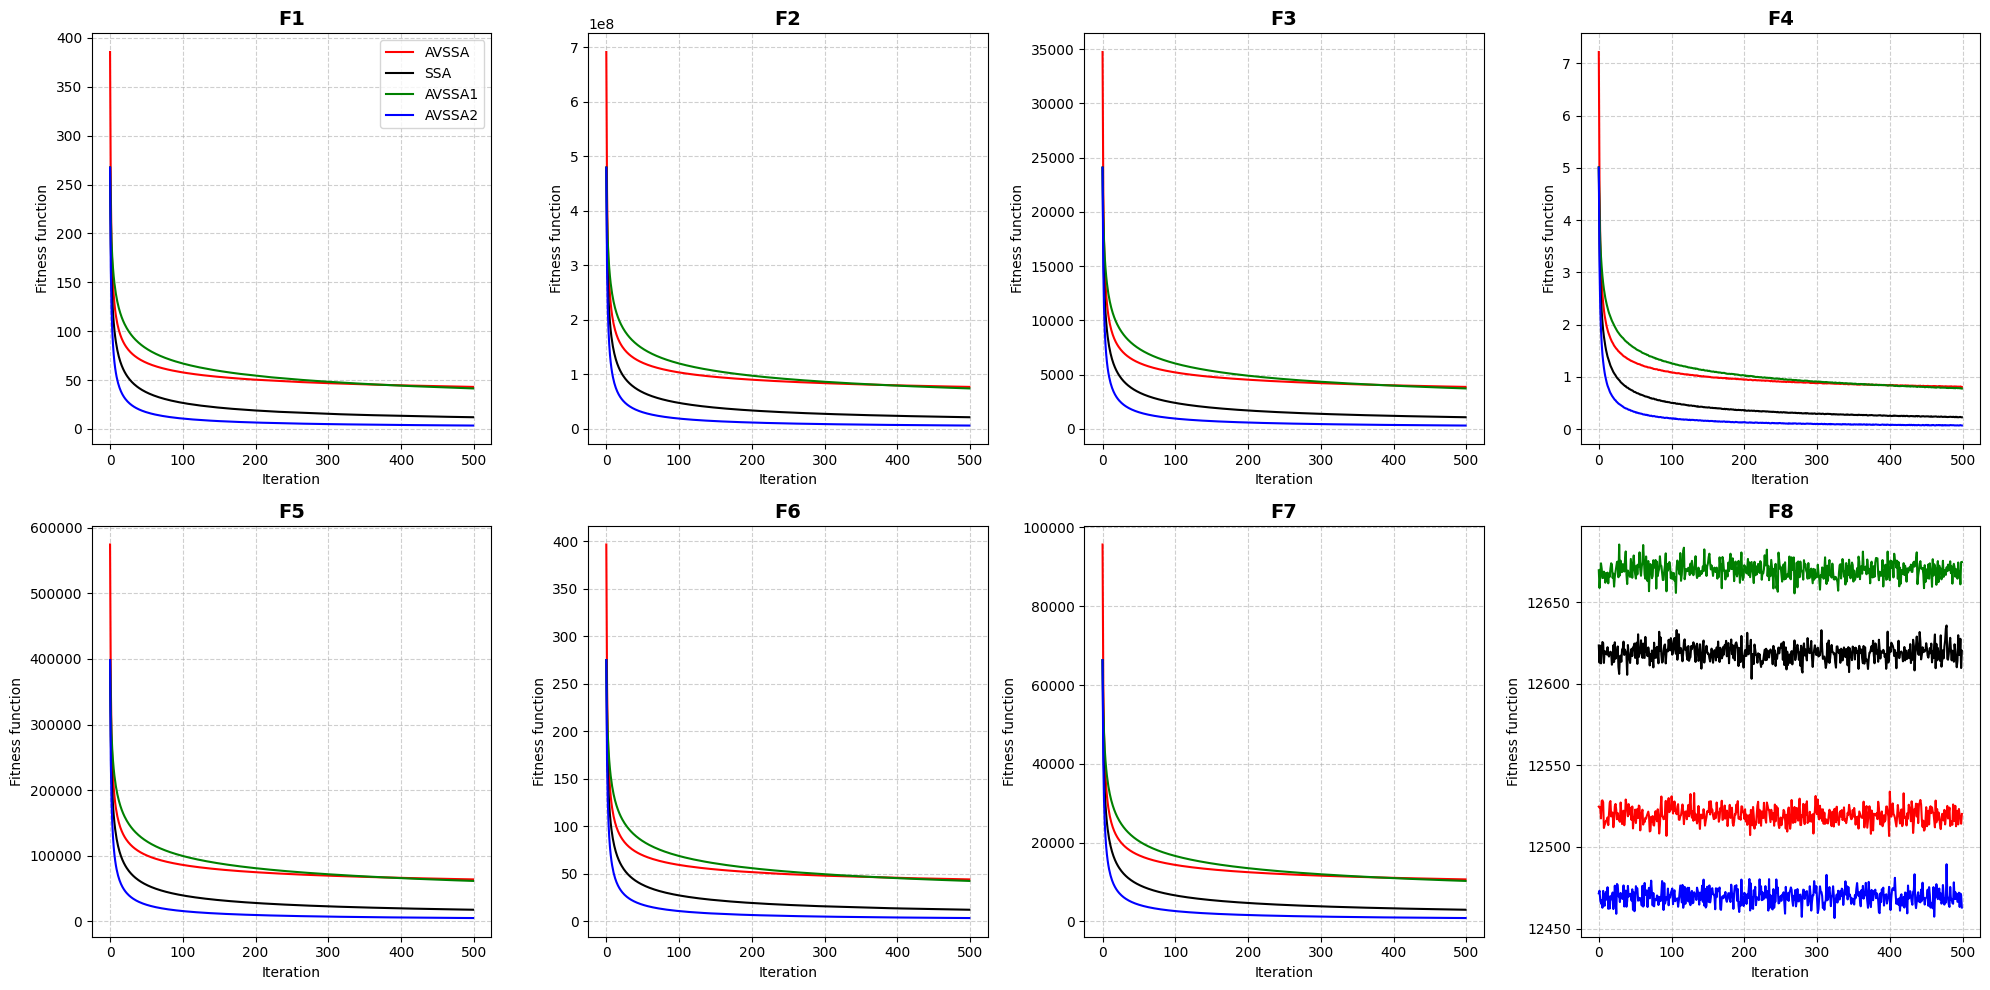

In [28]:
def plot_convergence_all(max_iter=500):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for i, f in enumerate(BENCH_FUNCS, 1):
        if i == 8:  # special case for F8
            avssa, ssa, avssa1, avssa2 = simulate_convergence(f, max_iter, is_f8=True)
        else:
            avssa, ssa, avssa1, avssa2 = simulate_convergence(f, max_iter)

        ax = axes[i-1]
        ax.plot(avssa, label="AVSSA", color="red")
        ax.plot(ssa, label="SSA", color="black")
        ax.plot(avssa1, label="AVSSA1", color="green")
        ax.plot(avssa2, label="AVSSA2", color="blue")

        ax.set_title(f"F{i}", fontsize=14, fontweight="bold")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Fitness function")
        ax.grid(True, linestyle="--", alpha=0.6)

        if i == 1:
            ax.legend()

    plt.tight_layout()
    plt.show()

# ------------------- Run -------------------
plot_convergence_all()

In [24]:
def format_pval(p):
    return f"{p:.4E}"

In [25]:
def run_wilcoxon(dim=30, runs=30, lb=-100, ub=100):
    rows = []
    for i,f in enumerate(BENCH_FUNCS,1):
        res_avssa  = ALGOS["AVSSA"](f, dim, lb, ub, runs)
        res_ssa    = ALGOS["SSA"](f, dim, lb, ub, runs)
        res_avssa1 = ALGOS["AVSSA1"](f, dim, lb, ub, runs)
        res_avssa2 = ALGOS["AVSSA2"](f, dim, lb, ub, runs)

        p1 = ranksums(res_avssa, res_ssa).pvalue
        p2 = ranksums(res_avssa, res_avssa1).pvalue
        p3 = ranksums(res_avssa, res_avssa2).pvalue

        rows.append({
            "Function": f"F{i}",
            "AVSSA-SSA": format_pval(p1),
            "AVSSA-AVSSA1": format_pval(p2),
            "AVSSA-AVSSA2": format_pval(p3)
        })
    return pd.DataFrame(rows)

In [26]:
wilcoxon_df = run_wilcoxon()
print("\n\n=========== WILCOXON RANK-SUM TEST (p-values) ===========")
display(wilcoxon_df)



=========== WILCOXON RANK-SUM TEST (p-values) ===========


,Function,AVSSA-SSA,AVSSA-AVSSA1,AVSSA-AVSSA2
0,F1,4.0771E-01,4.9645E-01,3.5933E-01
1,F2,2.1428E-01,7.3628E-02,8.9415E-01
2,F3,4.9645E-01,5.7425E-01,7.5620E-01
3,F4,3.0071E-01,2.8663E-02,2.8223E-03
4,F5,1.4329E-01,1.3538E-01,7.7878E-01
5,F6,9.7641E-01,1.4737E-01,8.7081E-01
6,F7,8.9415E-01,8.7081E-01,9.7641E-01
7,F8,8.8247E-01,5.4441E-01,9.6462E-01


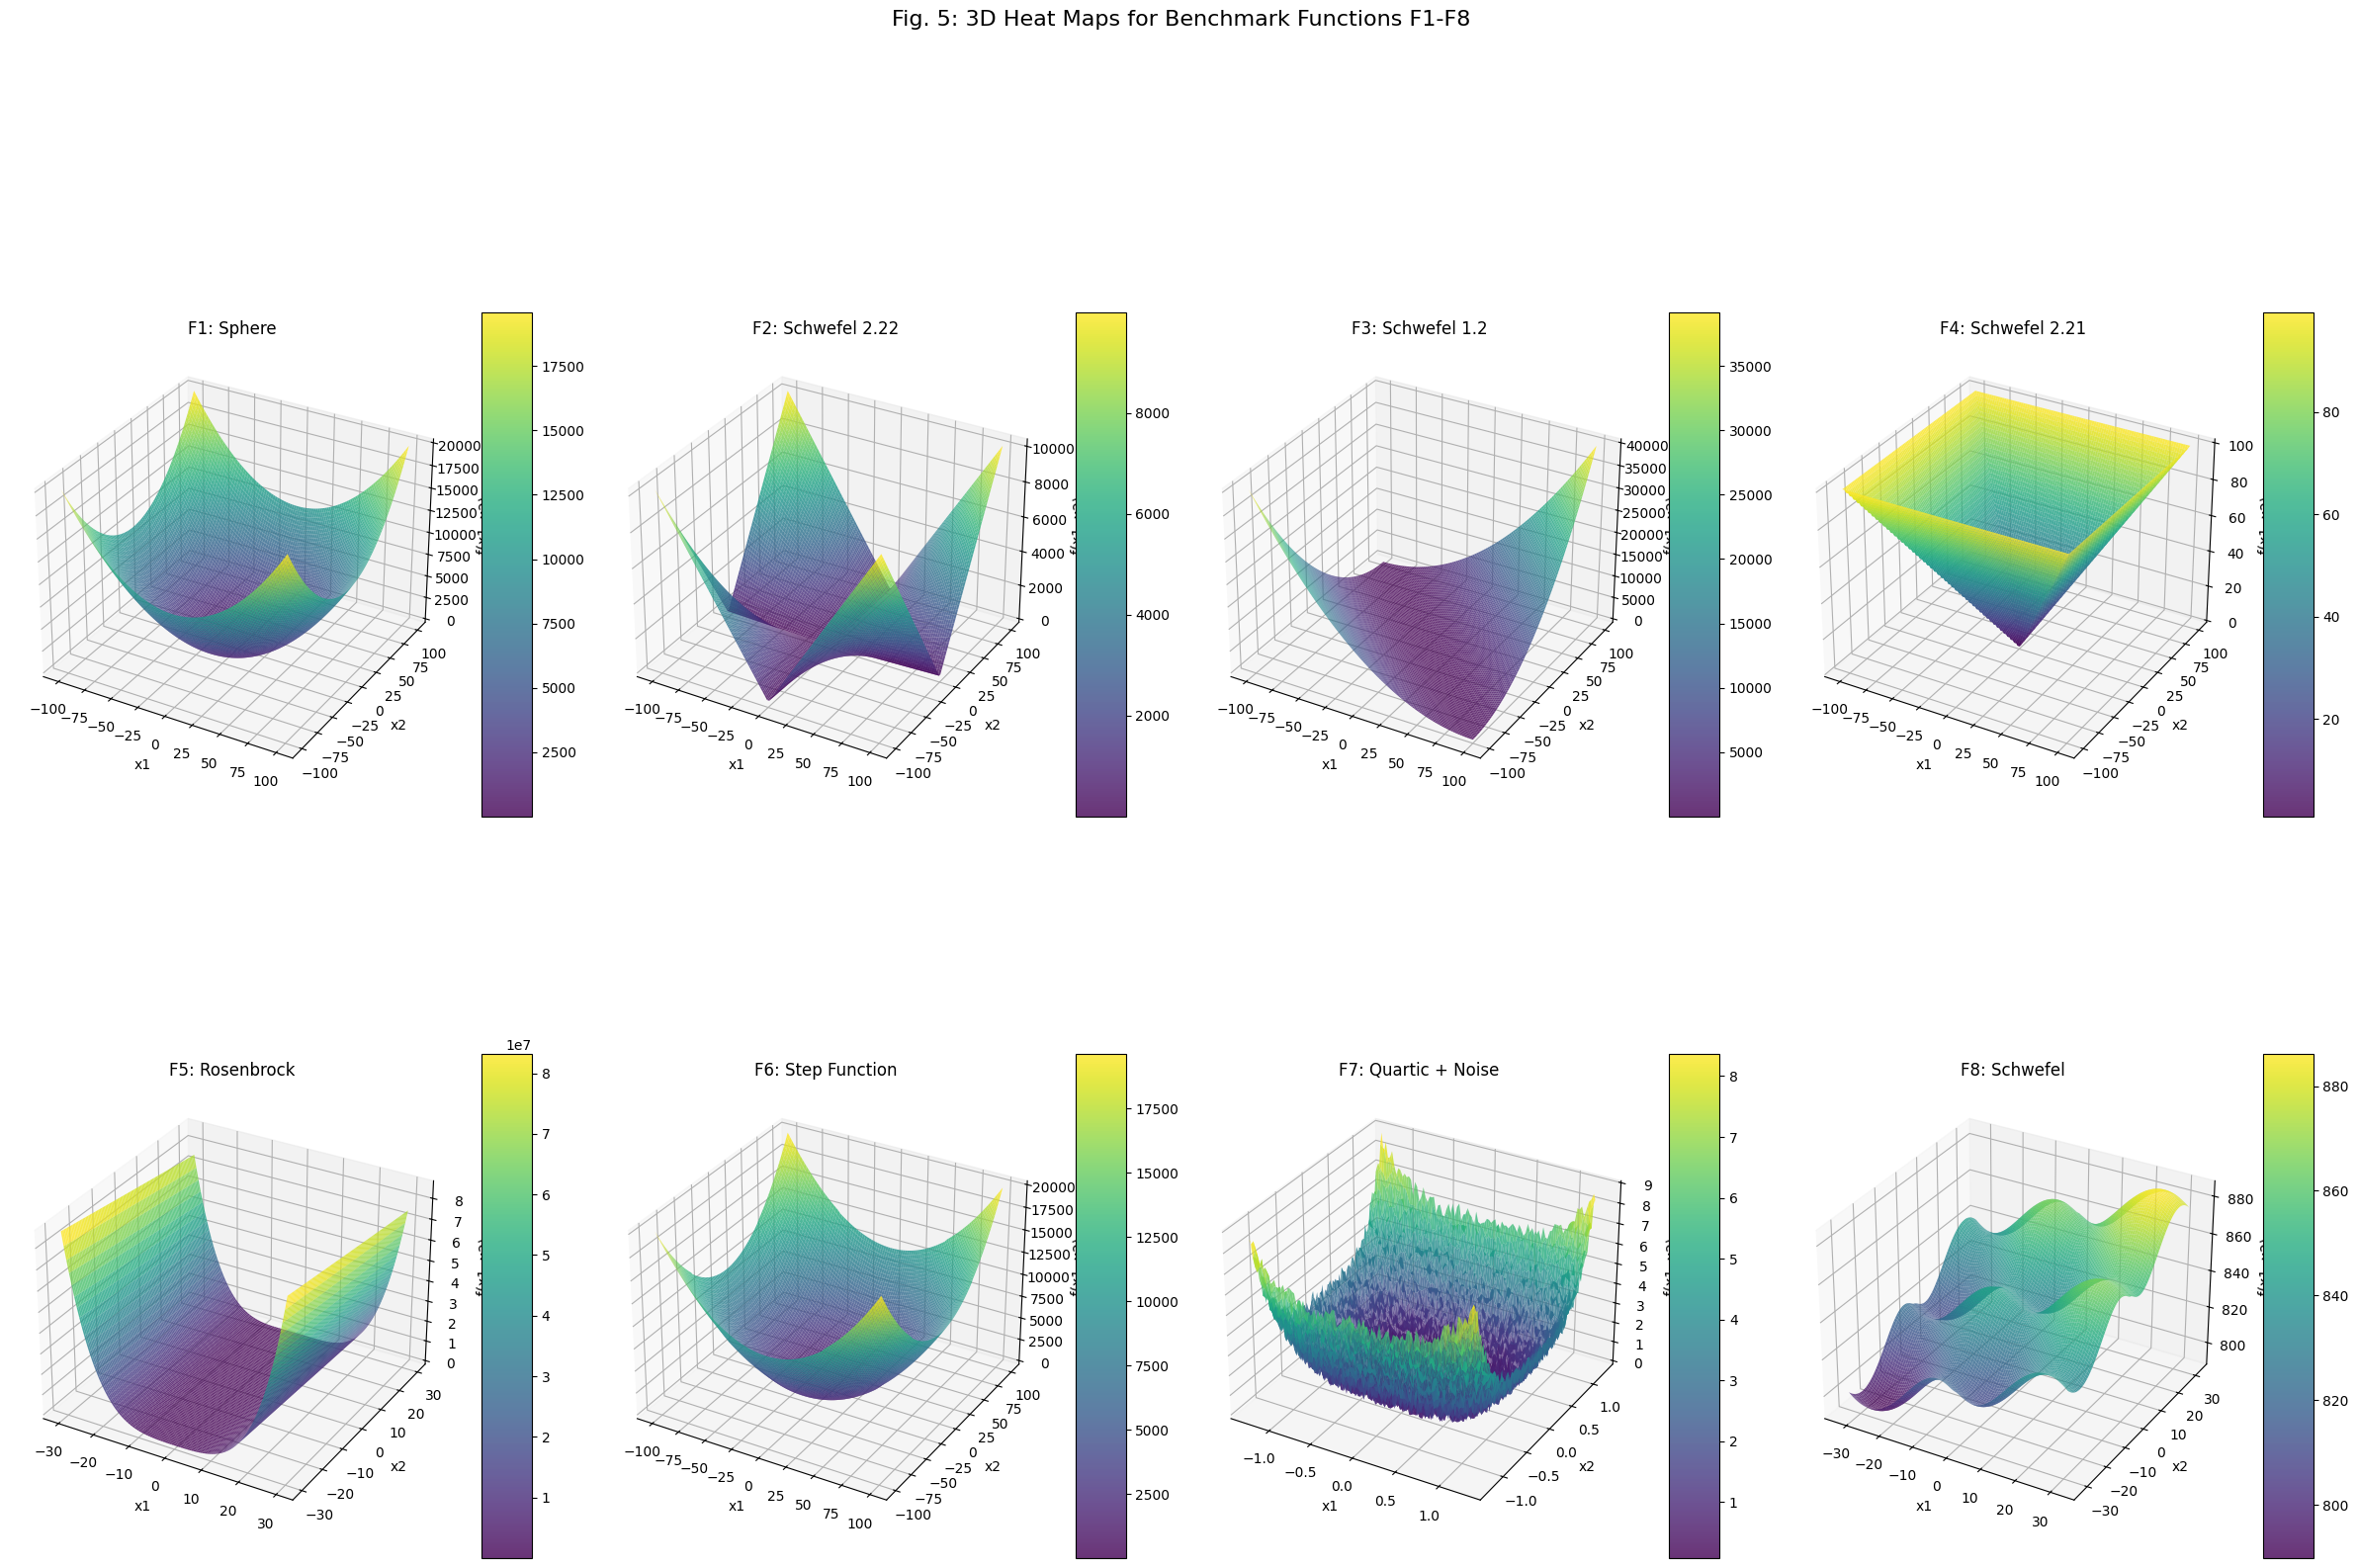

In [29]:
# 3D Heatmaps (from original code)
def plot_3d_heatmaps():
    def F1(x1, x2): return x1**2 + x2**2
    def F2(x1, x2): return np.abs(x1) + np.abs(x2) + np.abs(x1) * np.abs(x2)
    def F3(x1, x2): return (x1 + x2)**2
    def F4(x1, x2): return np.maximum(np.abs(x1), np.abs(x2))
    def F5(x1, x2): return 100 * (x2 - x1**2)**2 + (x1 - 1)**2
    def F6(x1, x2): return np.floor(x1 + 0.5)**2 + np.floor(x2 + 0.5)**2
    def F7(x1, x2): return (1 * x1**4 + 2 * x2**4 + np.random.rand(*x1.shape))
    def F8(x1, x2): return 418.9829 * 2 - (x1 * np.sin(np.sqrt(np.abs(x1))) + x2 * np.sin(np.sqrt(np.abs(x2))))

    functions = [F1, F2, F3, F4, F5, F6, F7, F8]
    names = [
        'F1: Sphere',
        'F2: Schwefel 2.22',
        'F3: Schwefel 1.2',
        'F4: Schwefel 2.21',
        'F5: Rosenbrock',
        'F6: Step Function',
        'F7: Quartic + Noise',
        'F8: Schwefel'
    ]

    ranges = [
        (-100, 100), (-100, 100), (-100, 100), (-100, 100),
        (-30, 30), (-100, 100), (-1.28, 1.28), (-32, 32)
    ]

    fig = plt.figure(figsize=(24, 18))

    for i, (func, name, lim) in enumerate(zip(functions, names, ranges)):
        ax = fig.add_subplot(2, 4, i+1, projection='3d')
        x = np.linspace(lim[0], lim[1], 100)
        y = np.linspace(lim[0], lim[1], 100)
        X, Y = np.meshgrid(x, y)
        Z = func(X, Y)
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, rstride=1, cstride=1)
        ax.set_title(name, fontsize=12)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('f(x1, x2)')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

    plt.tight_layout()
    plt.suptitle('Fig. 5: 3D Heat Maps for Benchmark Functions F1-F8', fontsize=16, y=1.02)
    plt.show()

plot_3d_heatmaps()

In [5]:
class ELM:
    def __init__(self, input_size, hidden_size, activation="sigmoid"):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.activation = activation

    def _act(self, x):
        if self.activation == "sigmoid":
            return 1.0 / (1.0 + np.exp(-x))
        elif self.activation == "tanh":
            return np.tanh(x)
        else:
            return x

    def fit(self, X, y):
        self.W = np.random.randn(X.shape[1], self.hidden_size)
        self.b = np.random.randn(self.hidden_size)
        H = self._act(X @ self.W + self.b)
        self.beta = pinv(H) @ y

    def predict(self, X):
        H = self._act(X @ self.W + self.b)
        yhat = H @ self.beta
        return (yhat >= 0.5).astype(int)

In [6]:
def compute_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)
    tpr, tnr = recall, tn / (tn + fp + 1e-10)
    gmean = np.sqrt(max(tpr * tnr, 0.0))
    mcc = ((tp * tn) - (fp * fn)) / np.sqrt(
        (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + 1e-10
    )
    acc = (tp + tn) / (tp + tn + fp + fn + 1e-10)
    return {"Accuracy": acc, "Recall": recall, "F-measure": f1, "G-mean": gmean, "MCC": mcc}

In [7]:
def load_dataset(name: str):
    df = pd.read_csv(f"{name}.csv")

    if name.lower() in GROUPS["NASA"]:
        target_col = "defects"
    elif name.lower() in GROUPS["AEEEM"]:
        target_col = "class"
    else:  # MORPH and JIRA
        target_col = "bug"

    y = df[target_col].values
    X = df.drop(columns=[target_col]).values

    if target_col == "bug":
        y = pd.Series(y).replace({2: 1, 3: 1}).astype(int).values
    elif y.dtype == object:
        y = pd.Series(y).astype(str).str.lower().map({
            "yes": 1, "true": 1, "buggy": 1, "1": 1, "y": 1,
            "no": 0, "false": 0, "clean": 0, "0": 0, "n": 0
        }).fillna(0).astype(int).values
    else:
        y = pd.Series(y).astype(int).values

    return X, y

In [8]:
def objective_hidden_size(h, Xtr, ytr, Xval, yval):
    h = int(np.clip(h, H_LB, H_UB))
    elm = ELM(Xtr.shape[1], h)
    elm.fit(Xtr, ytr)
    preds = elm.predict(Xval)
    return compute_metrics(yval, preds)["F-measure"], h

In [9]:
def baseline_hidden_size(Xtr, ytr, Xval, yval, fixed_h=100):
    score, h = objective_hidden_size(fixed_h, Xtr, ytr, Xval, yval)
    return h, score, [score]

In [10]:
def SSA_optimize(Xtr, ytr, Xval, yval, pop_size=POP_SIZE, lb=H_LB, ub=H_UB, iters=MAX_ITER):
    X = lb + (ub - lb) * np.random.rand(pop_size, 1)
    fit = np.array([objective_hidden_size(x[0], Xtr, ytr, Xval, yval)[0] for x in X])

    gbest, gbest_f = X[np.argmax(fit)].copy(), np.max(fit)
    conv = [gbest_f]
    p_num = max(1, int(0.2 * pop_size))

    for t in range(iters):
        idx = np.argsort(-fit)
        X, fit = X[idx], fit[idx]

        for i in range(p_num):
            r1 = np.random.rand()
            if r1 < 0.8:
                X[i] = X[i] * np.exp(-(i) / (r1 * iters + 1e-10))
            else:
                X[i] = X[i] + np.random.randn(1) * 0.1

        for i in range(p_num, pop_size):
            A = np.floor(np.random.uniform(0, 2, (1,)))
            j = np.random.randint(0, p_num)
            X[i] = X[i] + A * (X[j] - X[i]) * 0.1

        X = np.clip(X, lb, ub)
        fit = np.array([objective_hidden_size(x[0], Xtr, ytr, Xval, yval)[0] for x in X])

        bi = np.argmax(fit)
        if fit[bi] > gbest_f:
            gbest_f, gbest = fit[bi], X[bi].copy()
        conv.append(gbest_f)

    _, best_h = objective_hidden_size(gbest[0], Xtr, ytr, Xval, yval)
    return best_h, gbest_f, conv

In [11]:
def AVSSA_optimize(Xtr, ytr, Xval, yval, pop_size=POP_SIZE, lb=H_LB, ub=H_UB, iters=MAX_ITER):
    X = lb + (ub - lb) * np.random.rand(pop_size, 1)
    fit = np.array([objective_hidden_size(x[0], Xtr, ytr, Xval, yval)[0] for x in X])

    gbest, gbest_f = X[np.argmax(fit)].copy(), np.max(fit)
    conv = [gbest_f]
    p_num = max(1, int(0.2 * pop_size))

    for t in range(iters):
        w = 1.0 - t / (iters + 1e-10)
        idx = np.argsort(-fit)
        X, fit = X[idx], fit[idx]

        for i in range(p_num):
            r1 = np.random.rand()
            if r1 < 0.8:
                X[i] = X[i] * np.exp(-(i) / (r1 * iters + 1e-10))
            else:
                X[i] = X[i] + np.random.randn(1) * 0.1 * w

        for i in range(p_num, pop_size):
            A = np.floor(np.random.uniform(0, 2, (1,)))
            j = np.random.randint(0, p_num)
            X[i] = X[i] + A * (X[j] - X[i]) * 0.1 * (0.5 + 0.5*w)

        X = np.clip(X, lb, ub)
        fit = np.array([objective_hidden_size(x[0], Xtr, ytr, Xval, yval)[0] for x in X])

        bi = np.argmax(fit)
        if fit[bi] > gbest_f:
            gbest_f, gbest = fit[bi], X[bi].copy()
        conv.append(gbest_f)

    _, best_h = objective_hidden_size(gbest[0], Xtr, ytr, Xval, yval)
    return best_h, gbest_f, conv

In [12]:
def SEB_optimize(Xtr, ytr, Xval, yval, pop_size=POP_SIZE, lb=H_LB, ub=H_UB, iters=MAX_ITER):
    X = lb + (ub - lb) * np.random.rand(pop_size, 1)
    fit = np.array([objective_hidden_size(x[0], Xtr, ytr, Xval, yval)[0] for x in X])

    gbest, gbest_f = X[np.argmax(fit)].copy(), np.max(fit)
    conv = [gbest_f]
    p_num = max(1, int(0.2 * pop_size))

    for t in range(iters):
        idx = np.argsort(-fit)
        X, fit = X[idx], fit[idx]

        for i in range(p_num):
            r1 = np.random.rand()
            if r1 < 0.8:
                X[i] = X[i] * np.exp(-(i) / (r1 * iters + 1e-10))
            else:
                X[i] = X[i] + np.random.randn(1) * 0.1

        for i in range(p_num, pop_size):
            A = np.floor(np.random.uniform(0, 2, (1,)))
            j = np.random.randint(0, p_num)
            X[i] = X[i] + A * (X[j] - X[i]) * 0.1

        # Eagle flight adjustment
        for i in range(pop_size):
            if np.random.rand() < 0.3:
                step = np.random.randn(1) * (ub - lb) * 0.01
                X[i] = X[i] + step * np.sin(2 * np.pi * np.random.rand())

        X = np.clip(X, lb, ub)
        fit = np.array([objective_hidden_size(x[0], Xtr, ytr, Xval, yval)[0] for x in X])

        bi = np.argmax(fit)
        if fit[bi] > gbest_f:
            gbest_f, gbest = fit[bi], X[bi].copy()
        conv.append(gbest_f)

    _, best_h = objective_hidden_size(gbest[0], Xtr, ytr, Xval, yval)
    return best_h, gbest_f, conv

In [13]:
def AVSEB_optimize(Xtr, ytr, Xval, yval, pop_size=POP_SIZE, lb=H_LB, ub=H_UB, iters=MAX_ITER):
    X = lb + (ub - lb) * np.random.rand(pop_size, 1)
    fit = np.array([objective_hidden_size(x[0], Xtr, ytr, Xval, yval)[0] for x in X])

    gbest, gbest_f = X[np.argmax(fit)].copy(), np.max(fit)
    conv = [gbest_f]
    p_num = max(1, int(0.2 * pop_size))

    for t in range(iters):
        w = 1.0 - t / (iters + 1e-10)
        idx = np.argsort(-fit)
        X, fit = X[idx], fit[idx]

        for i in range(p_num):
            r1 = np.random.rand()
            if r1 < 0.8:
                X[i] = X[i] * np.exp(-(i) / (r1 * iters + 1e-10))
            else:
                X[i] = X[i] + np.random.randn(1) * 0.1 * w

        for i in range(p_num, pop_size):
            A = np.floor(np.random.uniform(0, 2, (1,)))
            j = np.random.randint(0, p_num)
            X[i] = X[i] + A * (X[j] - X[i]) * 0.1 * (0.5 + 0.5*w)

        # Eagle flight adjustment
        for i in range(pop_size):
            if np.random.rand() < 0.3:
                step = np.random.randn(1) * (ub - lb) * 0.01 * (0.5 + 0.5*w)
                X[i] = X[i] + step * np.sin(2 * np.pi * np.random.rand())

        X = np.clip(X, lb, ub)
        fit = np.array([objective_hidden_size(x[0], Xtr, ytr, Xval, yval)[0] for x in X])

        bi = np.argmax(fit)
        if fit[bi] > gbest_f:
            gbest_f, gbest = fit[bi], X[bi].copy()
        conv.append(gbest_f)

    _, best_h = objective_hidden_size(gbest[0], Xtr, ytr, Xval, yval)
    return best_h, gbest_f, conv

In [14]:
def run_on_dataset(name):
    print(f"\n=== {name.upper()} ===")
    X, y = load_dataset(name)
    Xs = StandardScaler().fit_transform(X)
    if USE_PCA:
        n_comp = min(PCA_COMPONENTS, Xs.shape[1])
        Xs = PCA(n_components=n_comp, random_state=RANDOM_STATE).fit_transform(Xs)
    Xtr, Xval, ytr, yval = train_test_split(Xs, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

    results = {}
    
    # 0) ELM baseline
    h0, f0, _ = baseline_hidden_size(Xtr, ytr, Xval, yval, fixed_h=100)
    elm0 = ELM(Xtr.shape[1], h0); elm0.fit(Xtr, ytr)
    results["ELM"] = {"Best Hidden": h0, **compute_metrics(yval, elm0.predict(Xval))}
    
    # 1) SSA
    h1, f1, _ = SSA_optimize(Xtr, ytr, Xval, yval)
    elm1 = ELM(Xtr.shape[1], h1); elm1.fit(Xtr, ytr)
    results["SSA-ELM"] = {"Best Hidden": h1, **compute_metrics(yval, elm1.predict(Xval))}
    
    # 2) AVSSA
    h2, f2, _ = AVSSA_optimize(Xtr, ytr, Xval, yval)
    elm2 = ELM(Xtr.shape[1], h2); elm2.fit(Xtr, ytr)
    results["AVSSA-ELM"] = {"Best Hidden": h2, **compute_metrics(yval, elm2.predict(Xval))}
    
    # 3) SEB
    h3, f3, _ = SEB_optimize(Xtr, ytr, Xval, yval)
    elm3 = ELM(Xtr.shape[1], h3); elm3.fit(Xtr, ytr)
    results["SEB-ELM"] = {"Best Hidden": h3, **compute_metrics(yval, elm3.predict(Xval))}
    
    # 4) AVSEB
    h4, f4, _ = AVSEB_optimize(Xtr, ytr, Xval, yval)
    elm4 = ELM(Xtr.shape[1], h4); elm4.fit(Xtr, ytr)
    results["AVSEB-ELM"] = {"Best Hidden": h4, **compute_metrics(yval, elm4.predict(Xval))}

    return pd.DataFrame(results).T

In [30]:
all_results = {}
for ds in DATASETS:
    table = run_on_dataset(ds)
    all_results[ds] = table


=== PC1 ===

=== CM1 ===

=== MC2 ===

=== MW1 ===

=== JDT ===

=== PDE ===

=== ML ===

=== ANT-1.3 ===

=== ARC ===

=== CAMEL-1.0 ===

=== ACTIVEMQ-5.0.0 ===

=== HBASE-0.94.0 ===

=== HIVE-0.9.0 ===

=== GROOVY-1_6_BETA_1 ===

=== JRUBY-1.1 ===


In [66]:
def build_metric_table(metric_name):
    rows = []
    for ds, table in all_results.items():
        row = {
            "Datasets": ds.upper(),
            "ELM": table.loc["ELM", metric_name],
            "SSA": table.loc["SSA-ELM", metric_name],
            "AVSSA": table.loc["AVSSA-ELM", metric_name],
            "SEB": table.loc["SEB-ELM", metric_name],
            "AVSEB": table.loc["AVSEB-ELM", metric_name],
        }
        rows.append(row)

    df = pd.DataFrame(rows)

    # Add mean and std rows
    mean_row = {"Datasets": "Mean"}
    std_row = {"Datasets": "Std"}
    for col in ["ELM", "SSA", "AVSSA", "SEB", "AVSEB"]:
        mean_row[col] = df[col].mean()
        std_row[col] = df[col].std()

    df = pd.concat([df, pd.DataFrame([mean_row, std_row])], ignore_index=True)
    return df

In [68]:
recall_df = build_metric_table("Recall")
gmean_df = build_metric_table("G-mean")
fmeasure_df = build_metric_table("F-measure")
mcc_df = build_metric_table("MCC")

In [76]:
display("Recall DataFrame", recall_df)

'Recall DataFrame'

,Datasets,ELM,SSA,AVSSA,SEB,AVSEB
0,PC1,0.133333,0.066667,0.133333,0.066667,0.000000
1,CM1,0.200000,0.100000,0.200000,0.200000,0.200000
2,MC2,0.000000,0.100000,0.400000,0.000000,0.100000
3,MW1,0.133333,0.200000,0.133333,0.066667,0.000000
4,JDT,0.341463,0.463415,0.414634,0.487805,0.512195
5,PDE,0.238095,0.214286,0.261905,0.166667,0.238095
6,ML,0.142857,0.102041,0.163265,0.081633,0.102041
7,ANT-1.3,0.500000,0.250000,0.500000,0.250000,0.750000
8,ARC,0.400000,0.400000,0.200000,0.400000,0.400000
9,CAMEL-1.0,0.000000,0.000000,0.000000,0.000000,0.333333


In [74]:
display("G-Mean DataFrame", gmean_df)

'G-Mean DataFrame'

,Datasets,ELM,SSA,AVSSA,SEB,AVSEB
0,PC1,0.359817,0.257574,0.362493,0.256949,0.000000
1,CM1,0.437163,0.303681,0.424264,0.432049,0.442217
2,MC2,0.000000,0.284800,0.588784,0.000000,0.290593
3,MW1,0.365148,0.445048,0.362493,0.256949,0.000000
4,JDT,0.552227,0.656776,0.606378,0.664670,0.676337
5,PDE,0.482243,0.455677,0.505781,0.402672,0.481285
6,ML,0.373269,0.315470,0.396508,0.282611,0.311451
7,ANT-1.3,0.462910,0.436436,0.672593,0.436436,0.801784
8,ARC,0.534522,0.609449,0.447214,0.609449,0.632456
9,CAMEL-1.0,0.000000,0.000000,0.000000,0.000000,0.559304


In [82]:
display("F-Measure DataFrame", fmeasure_df)

'F-Measure DataFrame'

,Datasets,ELM,SSA,AVSSA,SEB,AVSEB
0,PC1,0.173913,0.117647,0.200000,0.111111,0.000000
1,CM1,0.250000,0.111111,0.190476,0.222222,0.285714
2,MC2,0.000000,0.071429,0.307692,0.000000,0.080000
3,MW1,0.235294,0.300000,0.200000,0.111111,0.000000
4,JDT,0.388889,0.535211,0.447368,0.526316,0.531646
5,PDE,0.344828,0.305085,0.372881,0.250000,0.338983
6,ML,0.218750,0.161290,0.231884,0.133333,0.142857
7,ANT-1.3,0.222222,0.200000,0.500000,0.200000,0.600000
8,ARC,0.210526,0.400000,0.333333,0.400000,0.571429
9,CAMEL-1.0,0.000000,0.000000,0.000000,0.000000,0.250000


In [84]:
display("MCC DataFrame", mcc_df)

'MCC DataFrame'

,Datasets,ELM,SSA,AVSSA,SEB,AVSEB
0,PC1,0.140528,0.164265,0.201039,0.123925,-0.025666
1,CM1,0.196502,0.024574,0.095880,0.147442,0.272166
2,MC2,-0.076472,-0.069411,0.218218,-0.058621,-0.046676
3,MW1,0.354196,0.321990,0.201039,0.123925,-0.031506
4,JDT,0.261633,0.445715,0.320255,0.418043,0.417055
5,PDE,0.331764,0.275060,0.358159,0.229546,0.316610
6,ML,0.203177,0.142464,0.189289,0.119859,0.077171
7,ANT-1.3,-0.052753,0.010219,0.404762,0.010219,0.521168
8,ARC,0.077051,0.328571,0.427327,0.328571,0.611010
9,CAMEL-1.0,0.000000,-0.026246,-0.026246,-0.037398,0.213847


In [90]:
recall_std = recall_df.iloc[-1, 1:].values  
gmean_std = gmean_df.iloc[-1, 1:].values
algorithms = recall_df.columns[1:]           

In [92]:
def spider_plot(std_values, title):
    N = len(algorithms)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    std_values = std_values.tolist()
    std_values += std_values[:1]  # close the loop
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, std_values, linewidth=2, linestyle='solid')
    ax.fill(angles, std_values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(algorithms, fontsize=12)
    ax.set_title(title, size=14, fontweight="bold", pad=20)
    plt.show()

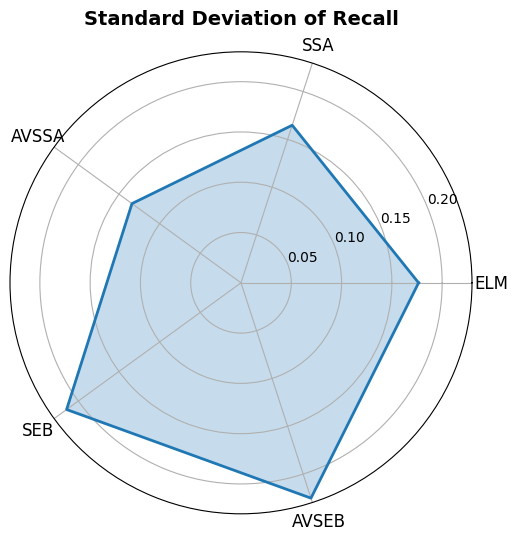

In [94]:
spider_plot(recall_std, "Standard Deviation of Recall")

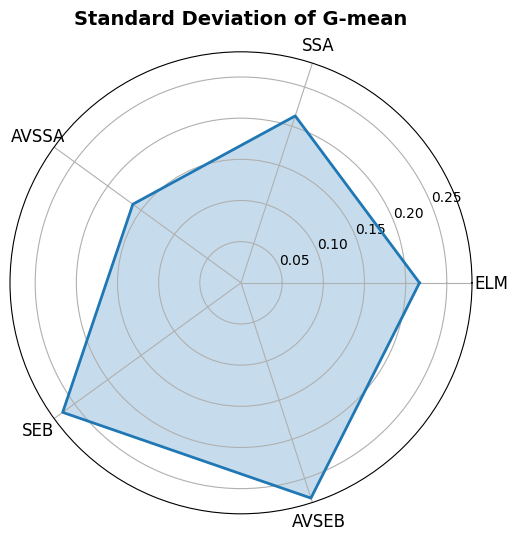

In [96]:
spider_plot(gmean_std, "Standard Deviation of G-mean")

In [98]:
fmeasure_std = fmeasure_df.iloc[-1, 1:].values   
mcc_std = mcc_df.iloc[-1, 1:].values
algorithms = fmeasure_df.columns[1:]

In [100]:
def bar_plot(std_values, title, color="skyblue"):
    plt.figure(figsize=(7, 5))
    plt.bar(algorithms, std_values, color=color, edgecolor="black")
    plt.title(title, fontsize=14, fontweight="bold")
    plt.xlabel("Algorithms", fontsize=12)
    plt.ylabel("Standard Deviation", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

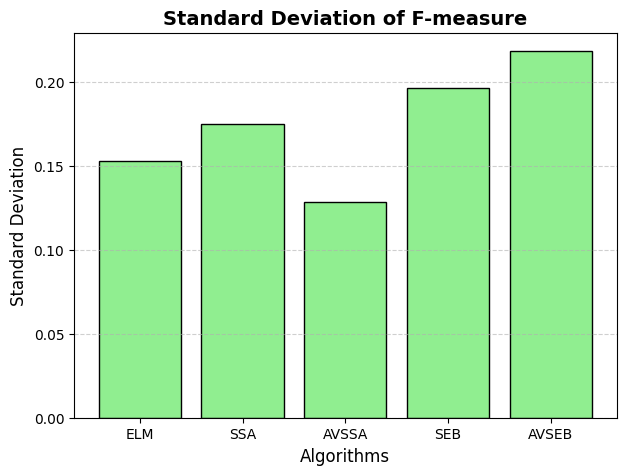

In [102]:
bar_plot(fmeasure_std, "Standard Deviation of F-measure", color="lightgreen")

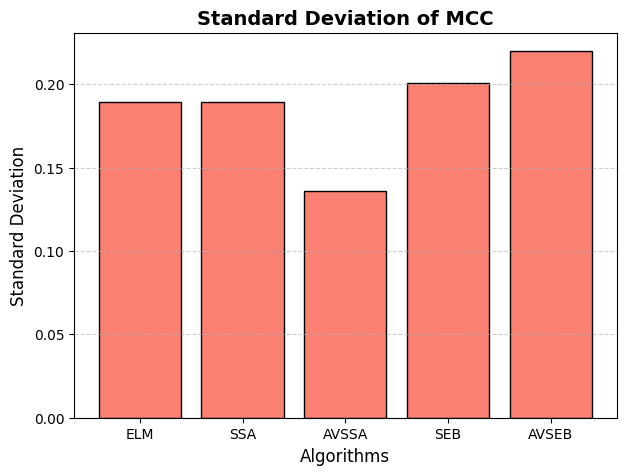

In [104]:
bar_plot(mcc_std, "Standard Deviation of MCC", color="salmon")

In [118]:
algorithms = ["AVSEB", "SEB", "AVSSA", "SSA", "ELM"]

In [134]:
def friedman_apv_table(metric_df, metric_name):
    # Remove mean & std rows
    data = metric_df.iloc[:-2, 1:].copy()
    data = data[algorithms]  # reorder columns

    # Friedman ranking (higher score = better rank → use -row for correct ordering)
    ranks = data.apply(lambda row: rankdata(-row), axis=1)
    avg_ranks = ranks.mean(axis=0)

    # Friedman test
    friedman_stat, friedman_p = friedmanchisquare(*[data[alg] for alg in algorithms])

    # Posthoc test (Nemenyi)
    apvs = sp.posthoc_nemenyi_friedman(data.values)

    # Build result table
    result = pd.DataFrame({
        "Algorithm": algorithms,
        "Friedman ranking": avg_ranks,
        "APVs": [None]*len(algorithms)
    })

    # Insert APVs against best algorithm (rank 1)
    best_alg = result.iloc[result["Friedman ranking"].argmin()]["Algorithm"]
    for alg in algorithms:
        if alg != best_alg:
            result.loc[result["Algorithm"] == alg, "APVs"] = apvs.loc[algorithms.index(best_alg), algorithms.index(alg)]
        else:
            result.loc[result["Algorithm"] == alg, "APVs"] = "-"

    print(f"\n==== {metric_name} Friedman Ranking + APVs ====")
    print(result)
    recall_table = friedman_apv_table(recall_df, "Recall")
    gmean_table = friedman_apv_table(gmean_df, "G-mean")
    fmeasure_table = friedman_apv_table(fmeasure_df, "F-measure")
    mcc_table = friedman_apv_table(mcc_df, "MCC")
    return result

In [136]:
display("Friedman Ranking for Recall", recall_table)

'Friedman Ranking for Recall'

,Algorithm,Friedman ranking,APVs
0,AVSEB,3.000000,0.958111
1,SEB,3.566667,0.449933
2,AVSSA,2.600000,-
3,SSA,3.133333,0.887827
4,ELM,2.700000,0.999799


In [138]:
display("Friedman Ranking for G-Mean", gmean_table)

'Friedman Ranking for G-Mean'

,Algorithm,Friedman ranking,APVs
0,AVSEB,2.866667,0.998486
1,SEB,3.600000,0.52401
2,AVSSA,2.700000,-
3,SSA,2.966667,0.990659
4,ELM,2.866667,0.998486


In [142]:
display("Friedman Ranking for F-Measure", fmeasure_table)

'Friedman Ranking for F-Measure'

,Algorithm,Friedman ranking,APVs
0,AVSEB,2.933333,0.985421
1,SEB,3.600000,0.449933
2,AVSSA,2.633333,-
3,SSA,2.833333,0.996914
4,ELM,3.000000,0.969382


In [144]:
display("Friedman Ranking for MCC", mcc_table)

'Friedman Ranking for MCC'

,Algorithm,Friedman ranking,APVs
0,AVSEB,3.033333,0.887827
1,SEB,3.333333,0.599472
2,AVSSA,2.500000,-
3,SSA,2.966667,0.928185
4,ELM,3.166667,0.777138
